# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv', index_col=0)
df_content = pd.read_csv('data/articles_community.csv', index_col=0)


# Show df to get an idea of the data
df.head()


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.tail()


,doc_body,doc_description,doc_full_name,doc_status,article_id
3266,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
3268,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
3272,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
3279,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
3281,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [3]:
#this creates a dataframe to indicate the articles that have been read by users
data = np.ones(45993)
data1 = pd.DataFrame({'read':data})
print(data1.head())

#this is then joined to user-item interaction dataframe
df_joined = df.join(data1)
print(df_joined.head())

   read
0   1.0
1   1.0
2   1.0
3   1.0
4   1.0
   article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  read  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7   1.0  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b   1.0  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074   1.0  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7   1.0  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2   1.0  


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
#grouping by email (in rows) and article_id (in columns)
#and indicating which articles users have read and how many times an articke has been read by users
train_data_df = df_joined.groupby(['email','article_id'])['read'].max().unstack()
print(train_data_df)
#as an example we can locate the articles that have been read by a particular user/email id
article_ids = train_data_df.loc['ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7'][train_data_df.loc['ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7'].isnull() == False].index.values
print(article_ids)

article_id                                0.0     2.0     4.0     8.0     \
email                                                                      
0000b6387a0366322d7fbfc6434af145adf7fed1     NaN     NaN     NaN     NaN   
001055fc0bb67f71e8fa17002342b256a30254cd     NaN     NaN     NaN     NaN   
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     NaN     NaN     NaN     NaN   
001a852ecbd6cc12ab77a785efa137b2646505fe     NaN     NaN     NaN     NaN   
001fc95b90da5c3cb12c501d201a915e4f093290     NaN     NaN     NaN     NaN   
0042719415c4fca7d30bd2d4e9d17c5fc570de13     NaN     NaN     NaN     NaN   
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     NaN     NaN     NaN     NaN   
008ba1d5b4ebf54babf516a2d5aa43e184865da5     NaN     NaN     NaN     NaN   
008ca24b82c41d513b3799d09ae276d37f92ce72     NaN     NaN     NaN     NaN   
008dfc7a327b5186244caec48e0ab61610a0c660     NaN     NaN     NaN     NaN   
009af4e0537378bf8e8caf0ad0e2994f954d822e     NaN     NaN     NaN     NaN   
00bda305223d

In [5]:
#this finds out the number of articles read by each user/email id 
df_group = df.groupby('email')['title']
no_of_articles_df = df_group.count()
no_of_articles_df = pd.DataFrame({'no_of_articles': no_of_articles_df})
print(no_of_articles_df.head())
#this sorts the number of articles read by each user from highest to lowest
sorted_values = no_of_articles_df.sort_values(['no_of_articles'],ascending=False)
# The maximum number of user-article interactions by any 1 user is found to be 364
print(sorted_values.head(20))

                                          no_of_articles
email                                                   
0000b6387a0366322d7fbfc6434af145adf7fed1              13
001055fc0bb67f71e8fa17002342b256a30254cd               4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621               3
001a852ecbd6cc12ab77a785efa137b2646505fe               6
001fc95b90da5c3cb12c501d201a915e4f093290               2
                                          no_of_articles
email                                                   
2b6c0f514c2f2b04ad3c4583407dccd0810469ee             364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a             363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66             170
a37adec71b667b297ed2440a9ff7dad427c7ac85             169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93             160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76             158
284d0c17905de71e209b376e3309c0b08134f7e2             148
18e7255ee311d4bd78f5993a9f09538e459e3fcc             147
d9032ff68d0fd45dfd18c0c5f732461

In [6]:
#to find median of user-article interactions, we find the total number of users first
length_emailid = len(sorted_values)
#if total number of users is an even number, median will be average of n(th)/2 and n+2(th)/2 values
if length_emailid % 2 == 0:
    val_1 = int(length_emailid / 2)
    val_2 = int((length_emailid + 2) / 2)
    median = 0.5*(sorted_values.values[val_1][0] + sorted_values.values[val_2][0])
#if total number of users is an odd number, median will be the n(th)+1/2 value
else:
    val_3 = int((length_emailid + 1) / 2)
    median = sorted_values.values[val_3/2][0]
#median is found to be 3
print(median)

3.0


In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with _3___ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is _364_____.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
# this lists out number of duplicate article for each article id, value is 1 if no duplicate
dups_message = df_content.pivot_table(index=['article_id'], aggfunc='size')
print(dups_message)
n = 0

#this appends article_id that have duplicate articles to a list
list = []
for i in dups_message:    
    if i != 1:
        print(dups_message.index[n], i)
        list.append(dups_message.index[n])
    n+=1
print(list)

#this prints out the rows in df_content that contain duplicate articles
for i in list:
    duplicates = df_content[df_content['article_id'] == i]
    print(duplicates)

article_id
0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1021    1
1022    1
1023    1
1024    1
1025    1
1026    1
1027    1
1028    1
1029    1
1030    1
1031    1
1032    1
1033    1
1034    1
1035    1
1036    1
1037    1
1038    1
1039    1
1040    1
1041    1
1042    1
1043    1
1044    1
1045    1
1046    1
1047    1
1048    1
1049    1
1050    1
Length: 1051, dtype: int64
50 2
221 2
232 2
398 2
577 2
[50, 221, 232, 398, 577]
                                               doc_body  \
129   Follow Sign in / Sign up Home About Insight Da...   
1103  Follow Sign in / Sign up Home About Insight Da...   

                                        doc_description  \
129                        Community Detection at Scale   
11

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset="doc_full_name", keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
df_content_articles_w_interations = df_content[df_content['article_id'].isin(df['article_id'])]
#The number of unique articles that have an interaction with a user
df_group = df.groupby('article_id')['email']
no_of_unique_articles = df_group.count()
print(len(no_of_unique_articles))

#The number of unique articles in the dataset
print(len(df_content))

#The number of unique users in the dataset
df_group = df.groupby('email')['title']
no_of_articles_df = df_group.count()
no_of_articles_df = pd.DataFrame({'no_of_articles': no_of_articles_df})
print(len(no_of_articles_df))

#The number of user-article interactions in the dataset
print(df.shape[0])

714
1051
5148
45993


In [11]:
unique_articles = 714#437 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993#45976 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
#this finds out how often each article_id was viewed
df_group_articleid = df.groupby('article_id')['email']
df_group_articleid_count = df_group_articleid.count()
df_group_articleid_count = pd.DataFrame({'article_id': df_group_articleid_count.index[:], 'no_of_views': df_group_articleid_count.values[:]})
print(df_group_articleid_count.head())
#this sort the number of times each article id is viewed in descending order
sorted_values_articleid = df_group_articleid_count.sort_values(['no_of_views'],ascending=False)
print(sorted_values_articleid.head(20))

   article_id  no_of_views
0         0.0           14
1         2.0           58
2         4.0           13
3         8.0           85
4         9.0           10
     article_id  no_of_views
699      1429.0          937
625      1330.0          927
701      1431.0          671
697      1427.0          643
652      1364.0          627
614      1314.0          614
600      1293.0          572
526      1170.0          565
518      1162.0          512
608      1304.0          483
706      1436.0          481
583      1271.0          473
671      1398.0          465
22         43.0          460
641      1351.0          457
666      1393.0          454
540      1185.0          442
516      1160.0          433
642      1354.0          426
656      1368.0          418


In [13]:
#this function finds out the article title for an article_id
def find_article_name(article_id):
    article_names = np.unique(df[df['article_id'].isin(article_id)]['title'])
    return article_names

#we will find the article title for the most viewed article_id, namely 1429
find_article_name([1429.0])[0]
#the article title for article_id 1429 is 'use deep learning for image classification'

'use deep learning for image classification'

In [14]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head(30)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
5,1432.0,visualize data with the matplotlib library,6
6,1429.0,use deep learning for image classification,7
7,593.0,upload files to ibm data science experience us...,8
8,1314.0,healthcare python streaming application demo,9
9,1185.0,classify tumors with machine learning,10


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_group_articleid = df.groupby('title')['user_id']
    df_group_articleid_count = df_group_articleid.count()
    df_group_articleid_count = pd.DataFrame({'articles_title': df_group_articleid_count.index[:], 'no_of_views': df_group_articleid_count.values[:]})
    sorted_values_articleid = df_group_articleid_count.sort_values(['no_of_views'],ascending=False)
    top_articles = sorted_values_articleid['articles_title'][0:n]
    print(df_group_articleid_count['no_of_views'].sum())

    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_group_articleid1 = df.groupby('article_id')['user_id']
    df_group_articleid1_count = df_group_articleid1.count()
    df_group_articleid1_count = pd.DataFrame({'articles_id': df_group_articleid1_count.index[:], 'no_of_views': df_group_articleid1_count.values[:]})
    sorted_values1_articleid = df_group_articleid1_count.sort_values(['no_of_views'],ascending=False)
    top_articles = sorted_values1_articleid['articles_id'][0:n]
    print(df_group_articleid1_count['no_of_views'].sum())
 
    return top_articles # Return the top article ids

In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

45993
45993
45993
45993
45993
45993
Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    data[:] = int(1)

    data1 = pd.DataFrame({'read':data})
    df_joined = df.join(data1)
    train_data_df = df_joined.groupby(['user_id','article_id'])['read'].max().unstack()
    train_data_df_rem_na = train_data_df.fillna(value=0)
    
    return train_data_df_rem_na # return the user_item matrix 
    

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # sort by similarity
    # create list of just the ids
    # remove the own user's id
    
    user_item_array = np.array(user_item)
    user_item_index = user_item.index
    
    user_item_columns = user_item.columns

    user_row = np.where(user_item_index == user_id)[0][0]

    dot_prod_user_item = user_item_array.dot(np.transpose(user_item_array))

    user_item_filtered = dot_prod_user_item[user_row]
    indices = user_item_filtered.argsort()[::-1]

    user_id_similar = (user_item_index[indices].tolist())
    user_id_similar.remove(user_id)
       
    return user_id_similar # return a list of the users in order from most to least similar      

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

#print("The 3 most similar users to user 46 are: {}".format(find_similar_users(50)[:10]))
#print("The 3 most similar users to user 46 are: {}".format(find_similar_users(25)[:10]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 4459, 203, 3870, 131, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459, 4201, 46, 3870, 131, 3697]
The 3 most similar users to user 46 are: [4201, 23, 3782, 203, 4459, 2982, 3764, 98, 290, 3697]
The 3 most similar users to user 46 are: [3478, 49, 3697, 3596, 52, 4526, 3647, 4145, 518, 207]
The 3 most similar users to user 46 are: [3601, 3782, 734, 64, 3061, 135, 383, 4619, 4932, 621]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = np.unique(df[df['article_id'].isin(article_ids)]['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = []
    article_ids_0 = user_item.loc[user_id][user_item.loc[user_id] != 0].index.values
    for i in article_ids_0:
        article_ids.append(str(i))
        
    article_names = np.unique(df[df['article_id'].isin(article_ids)]['title'])
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = np.array([])
    user_id_similar = find_similar_users(user_id)
    articles_read = user_item.loc[user_id][user_item.loc[user_id] != 0].index.values
    for i in user_id_similar:
        similar_users_read = user_item.loc[i][user_item.loc[i] != 0].index.values
        new_recomm_articles = np.setdiff1d(similar_users_read, articles_read , assume_unique=True)
        recs = np.unique(np.concatenate([recs,new_recomm_articles], axis=0))
        if len(recs) == m:
            break
    recs = recs[0:10]
    return recs # return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array([ '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
       'analyze ny restaurant data using spark in dsx',
       'apache spark™ 2.0: extend structured streaming for spark ml',
       'data science bowl 2017',
       'detect malfunctioning iot sensors with streaming analytics',
       'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'higher-order logistic regression for large datasets',
       'the greatest public datasets for ai – startup grind',
       'this week in data science (april 18, 2017)',
       'timeseries data analysis of iot events by using jupyter notebook'], dtype=object)

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_item_array = np.array(user_item)
    user_item_index = user_item.index

    user_item_columns = user_item.columns
    user_row = np.where(user_item_index == user_id)[0][0]

    dot_prod_user_item = user_item_array.dot(np.transpose(user_item_array))
    user_item_filtered = dot_prod_user_item[user_row]
    user_item_filtered_1 = np.delete(user_item_filtered, user_row)
    user_item_filtered_1 = np.sort(user_item_filtered_1)[::-1]


    indices = user_item_filtered.argsort()[::-1]
    similar_users = (user_item_index[indices].tolist())
    similar_users.remove(user_id)

    df_group_userid1 = df.groupby('user_id')['title']
    df_group_userid1_count = df_group_userid1.count()
    df_group_userid1_count = pd.DataFrame({'user_id': df_group_userid1_count.index[:], 'no_of_views': df_group_userid1_count.values[:]})
    sorted_values_userid1 = df_group_userid1_count.sort_values(['no_of_views'],ascending=False)

    l=[]
    k=[]
    m=1
    p=pd.DataFrame()
    q=pd.DataFrame()
    for i in range(len(user_item_filtered_1)):
        if i == (len(user_item_filtered_1) - 1):
            break
        if user_item_filtered_1[i+1] == user_item_filtered_1[i]:
            m += 1
            l.append(similar_users[i])
            continue
        else:
            l.append(similar_users[i])
            for j in l:
                no_of_views = sorted_values_userid1[sorted_values_userid1['user_id']==j]
                p = pd.concat([p,no_of_views])
            p = p.sort_values(['no_of_views'],ascending = False)
            q = pd.concat([q,p])
            l = []
            p = pd.DataFrame()    
    neighbors_df = q.copy()
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    df_group_articleid = df.groupby('article_id')['title']
    df_group_articleid_count = df_group_articleid.count()
    df_group_articleid_count = pd.DataFrame({'article_id': df_group_articleid_count.index[:], 'no_of_views': df_group_articleid_count.values[:]})
    sorted_values_articleid = df_group_articleid_count.sort_values(['no_of_views'],ascending=False)
    
    v = pd.DataFrame()
    w = pd.DataFrame()
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    for user_id in neighbors_df['user_id']:
        articles_read = user_item.loc[user_id][user_item.loc[user_id] != 0].index.values.tolist()
    
        for j in articles_read:
            no_of_views = sorted_values_articleid[sorted_values_articleid['article_id']==j]
            v = pd.concat([v,no_of_views])
            v = v.sort_values(['no_of_views'],ascending = False)
            w = pd.concat([w,v])
            v = pd.DataFrame()
            
    recs = w['article_id'].tolist()[0:m]
    rec_names = np.unique(df[df['article_id'].isin(recs)]['title'])
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12.0, 109.0, 125.0, 142.0, 164.0, 205.0, 232.0, 302.0, 336.0, 362.0]

The top 10 recommendations for user 20 are the following article names:
["a beginner's guide to variational methods"
 'accelerate your workflow with dsx' 'challenges in deep learning'
 'dsx: hybrid mode' 'learn tensorflow and deep learning together and now!'
 'neural networks for beginners: popular types and applications'
 'self-service data preparation with ibm data refinery'
 'statistics for hackers' 'tensorflow quick tips'
 'timeseries data analysis of iot events by using jupyter notebook']


In [28]:
user1_sim_df = (get_top_sorted_users(user_id=1, df=df, user_item=user_item)).reset_index(drop=True)
print(user1_sim_df['user_id'][0])
user131_sim_df = get_top_sorted_users(user_id=131, df=df, user_item=user_item).reset_index(drop=True)
print(user131_sim_df['user_id'][9])

3933
242


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
We will use get_top_article_ids function to recommend the most viewed articles by existing users. This is because we have no information about the user's article view history, so will not be able to find other users similar to our new user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:

new_user = '0.0'
df_group_articleid = df.groupby('article_id')['user_id']
df_group_articleid_count = df_group_articleid.count()
df_group_articleid_count = pd.DataFrame({'article_id': df_group_articleid_count.index[:], 'no_of_views': df_group_articleid_count.values[:]})
#this sort the number of times each article id is viewed in descending order
sorted_values_articleid = df_group_articleid_count.sort_values(['no_of_views'],ascending=False)
new_user_recs=(sorted_values_articleid['article_id'])[0:10].astype(str)

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = (sorted_values_articleid['article_id'])[0:10].astype(str)
# Your recommendations here


In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape
#u, s, vt = # use the built in to get the three matrices

((714,), (5149, 5149), (714, 714))

**Provide your response here.**
In the lesson, FunkSVD is used because the user_item_matrix contains NaN values since some users have no ratings for certain movies, while the user-item matrix here has no NaN values, only 0 or 1 to indicate if a user has viewed an article or not

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

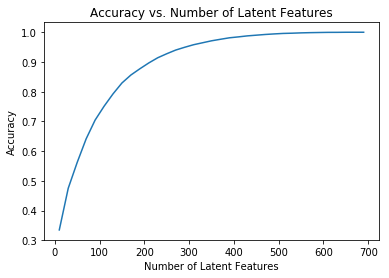

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    data[:] = int(1)
    data1 = pd.DataFrame({'read':data})
    df_joined1 = df_train.join(data1)
    user_item_train = df_joined1.groupby(['user_id','article_id'])['read'].max().unstack()
    user_item_train = user_item_train.fillna(value=0) 
    df_joined2 = df_test.join(data1)
    user_item_test = df_joined2.groupby(['user_id','article_id'])['read'].max().unstack()
    user_item_test = user_item_test.fillna(value=0)    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [40]:
#this is for how many users in the test set are we not able to make predictions for because of the cold start problem
g=0
for i in test_idx:
    if not i in df_train['user_id'].tolist():
        g+=1
print(g)
#this is for how many users can we make predictions for in the test set?
print(len(test_idx) - g)
#this is for how many movies in the test set are we not able to make predictions for because of the cold start problem?
h=0
for i in test_arts:
    if not i in df_train['article_id'].tolist():
        h+=1
print(h)
#this is for how many movies can we make predictions for in the test set?
print(len(test_arts) - h)

662
20
0
574


In [41]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662, # letter here, 
    'How many movies can we make predictions for in the test set?': 574 ,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': 0# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [42]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [43]:
print(user_item_train)

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8              0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
9              0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
10             0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
11             0.0     0.0     0.0     0.0     0.0     1.0     0

In [44]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [45]:
idx_similar = user_item_train.index.isin(test_idx)
arts_similar = user_item_train.columns.isin(test_arts)
u_test = u_train[idx_similar, :]
vt_test = vt_train[:, arts_similar]

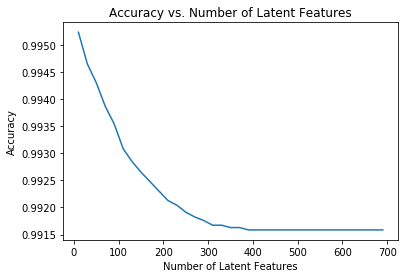

In [51]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_1 = []


for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_1, vt_new_1 = u_test[:, :k], vt_test[:k, :]
    # take dot product
    user_item_est_1 = np.around(np.dot(np.dot(u_new_1, s_new), vt_new_1))
    # compute error for each prediction to actual value
    diffs_1 = np.subtract(user_item_test.loc[user_item_matrix.loc[idx_similar, :].index, :], user_item_est_1)
    
    # total errors and keep track of them   
    err_1 = np.sum(np.sum(np.abs(diffs_1)))
    
    sum_errs_1.append(err_1)
    

#print(sum_errs_1)
#print(num_latent_feats)
plt.plot(num_latent_feats, 1 - np.array(sum_errs_1)/(df.shape[0]))
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
The accuracy decreases as more latent features are added. This is due to overfitting problem, which causes the training decomposition not able to generalize well on the test data.
We can use A/B testing to find out if our recommendation system is an improvement. We separate users into two group, one group using our recommendafion system, the other using the old method. We will conduct t-test on the difference of view counts of recommended articles of both groups (treatment group - control group) and if the test is statistically significant, we can conclude that our recommendation system is an improvement.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0